In [81]:
import torch
import torchvision
from torchvision import transforms # 이미지 데이터 transform
from torch.utils.data import DataLoader # 이미지 데이터 로더
import os
import glob

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [82]:
train_path = 'C:/Users/drago/Tank_data/train'
test_path = 'C:/Users/drago/Tank_data/test'

Challenger2_dir = '/Challenger2/'
K2_dir = '/K2/'
Leopard2_dir = '/Leopard2/'

In [83]:
image_size=256
transform_train = transforms.Compose([
    transforms.Resize((image_size, image_size)), # 이미지 resize
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
])

trainset = torchvision.datasets.ImageFolder(root=train_path, transform=transform_train)
testset = torchvision.datasets.ImageFolder(root=test_path, transform=transform_test)

In [84]:
#batchSize
batchSize=32

In [85]:
#dataloader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchSize,
                                          shuffle=True, num_workers=0)

testloader = torch.utils.data.DataLoader(testset, batch_size=batchSize,
                                         shuffle=False, num_workers=0)

In [86]:
print(trainset[0][0].shape)
print(trainset)
print(testset)

torch.Size([3, 256, 256])
Dataset ImageFolder
    Number of datapoints: 2021
    Root location: C:/Users/drago/Tank_data/train
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )
Dataset ImageFolder
    Number of datapoints: 506
    Root location: C:/Users/drago/Tank_data/test
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )


In [87]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1): #in planes --> input  , out planes --> output
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

class Bottleneck(nn.Module):

    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=3, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None, # me --> stride with dilation 을 바꿔야함
                 norm_layer=None):
        super(ResNet, self).__init__() #상속
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64 #input feature map (channel)
        self.dilation = 1 #dilation is 1
        if replace_stride_with_dilation is None: # dilation is none -> 실행
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        #kernel_size=7 stride = 2 padding = 3
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 32, layers[0])
        self.layer2 = self._make_layer(block, 64, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 128, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 256, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256 * block.expansion, num_classes)


    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride #stride 대신 dilation
            stride = 1

        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups, # block == bottleneck 구조 class
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x,1)
        x = self.fc(x)

        return x

    def forward(self, x):
        return self._forward_impl(x)


In [88]:
model = ResNet(Bottleneck, [3, 4, 6, 3],3,True).to(device)

In [89]:
from torchsummary import summary
summary(model, input_size=(3, 256, 256), device=device)

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            9,472
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
|    └─Bottleneck: 2-1                   --
|    |    └─Conv2d: 3-1                  2,048
|    |    └─BatchNorm2d: 3-2             64
|    |    └─Conv2d: 3-3                  9,216
|    |    └─BatchNorm2d: 3-4             64
|    |    └─Conv2d: 3-5                  4,096
|    |    └─BatchNorm2d: 3-6             256
|    |    └─ReLU: 3-7                    --
|    |    └─Sequential: 3-8              8,448
|    └─Bottleneck: 2-2                   --
|    |    └─Conv2d: 3-9                  4,096
|    |    └─BatchNorm2d: 3-10            64
|    |    └─Conv2d: 3-11                 9,216
|    |    └─BatchNorm2d: 3-12            64
|    |    └─Conv2d: 3-13                 4,096
|    |    └─BatchNorm2d: 3-14            256


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            9,472
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
|    └─Bottleneck: 2-1                   --
|    |    └─Conv2d: 3-1                  2,048
|    |    └─BatchNorm2d: 3-2             64
|    |    └─Conv2d: 3-3                  9,216
|    |    └─BatchNorm2d: 3-4             64
|    |    └─Conv2d: 3-5                  4,096
|    |    └─BatchNorm2d: 3-6             256
|    |    └─ReLU: 3-7                    --
|    |    └─Sequential: 3-8              8,448
|    └─Bottleneck: 2-2                   --
|    |    └─Conv2d: 3-9                  4,096
|    |    └─BatchNorm2d: 3-10            64
|    |    └─Conv2d: 3-11                 9,216
|    |    └─BatchNorm2d: 3-12            64
|    |    └─Conv2d: 3-13                 4,096
|    |    └─BatchNorm2d: 3-14            256


In [90]:
import torch.optim as optim

"""
lr = 0.0008

optimizer = 'Adam'
"""

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [91]:
epochs = 100

In [93]:
import torch, gc

gc.collect()
torch.cuda.empty_cache()

In [94]:
train_loss=[]
test_accuracy=[]

for epoch in range(epochs):
    running_loss = 0.0
    running_acc = 0.0

    for i, (images, labels) in enumerate (trainloader,0):
        images=images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
                                                                                                            # predict classes using images from the training set
        outputs = model(images)
        loss = criterion(outputs, labels)
                                                                                                                                                        # backpropagate the loss
        loss.backward()
        optimizer.step()

                                                                                                                                                                                                           # Let's print statistics for every 1,000 images
        running_loss += loss.item()     # extract the loss value

    train_loss.append(running_loss)

    print('[%d, %5d] loss: %.3f' %(epoch + 1, epochs, running_loss ))

    model.eval()
    accuracy = 0.0
    total = 0.0


    with torch.no_grad():
        for i, (images, labels) in enumerate (testloader,0):

            images=images.to(device)
            labels = labels.to(device)
            outputs = model(images)
              # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()
        
        # compute the accuracy over all test images
        accuracy = (100 * accuracy / total)
        test_accuracy.append(accuracy)
        print('For epoch', epoch+1,'the test accuracy over the whole test set is %d %%' % (accuracy))



[1,   100] loss: 70.327
For epoch 1 the test accuracy over the whole test set is 34 %
[2,   100] loss: 70.328
For epoch 2 the test accuracy over the whole test set is 34 %
[3,   100] loss: 70.323
For epoch 3 the test accuracy over the whole test set is 33 %
[4,   100] loss: 70.317
For epoch 4 the test accuracy over the whole test set is 33 %
[5,   100] loss: 70.312
For epoch 5 the test accuracy over the whole test set is 33 %
[6,   100] loss: 70.310
For epoch 6 the test accuracy over the whole test set is 33 %
[7,   100] loss: 70.316
For epoch 7 the test accuracy over the whole test set is 41 %
[8,   100] loss: 70.307
For epoch 8 the test accuracy over the whole test set is 33 %
[9,   100] loss: 70.306
For epoch 9 the test accuracy over the whole test set is 36 %
[10,   100] loss: 70.304
For epoch 10 the test accuracy over the whole test set is 40 %
[11,   100] loss: 70.295
For epoch 11 the test accuracy over the whole test set is 35 %
[12,   100] loss: 70.300
For epoch 12 the test acc

[95,   100] loss: 69.647
For epoch 95 the test accuracy over the whole test set is 37 %
[96,   100] loss: 69.653
For epoch 96 the test accuracy over the whole test set is 34 %
[97,   100] loss: 69.593
For epoch 97 the test accuracy over the whole test set is 37 %
[98,   100] loss: 69.499
For epoch 98 the test accuracy over the whole test set is 36 %
[99,   100] loss: 69.491
For epoch 99 the test accuracy over the whole test set is 37 %
[100,   100] loss: 69.636
For epoch 100 the test accuracy over the whole test set is 35 %


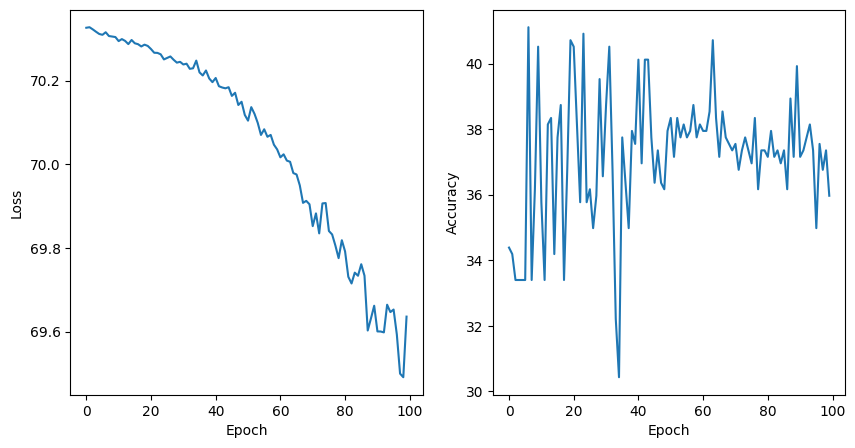

"\nnp.save('/content/drive/My Drive/Final_Turm_model_result_save/dilation_fpn_train_loss_100',train_loss)\nnp.save('/content/drive/My Drive/Final_Turm_model_result_save/dilation_fpn_test_accuracy_100',test_accuracy)\n"

In [95]:
import numpy as np
import matplotlib.pyplot as plt

_epochs = np.arange(0,epochs)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(_epochs,train_loss)
plt.subplot(1,2,2)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(_epochs, test_accuracy)
plt.show()

train_loss=np.array(train_loss)
test_accuracy=np.array(test_accuracy)
"""
np.save('/content/drive/My Drive/Final_Turm_model_result_save/dilation_fpn_train_loss_100',train_loss)
np.save('/content/drive/My Drive/Final_Turm_model_result_save/dilation_fpn_test_accuracy_100',test_accuracy)
"""

In [96]:
np.save('C:/Users/drago/Learning_result/ResNet_train_loss_100',train_loss)
np.save('C:/Users/drago/Learning_result/ResNet_test_accuracy_100',test_accuracy)
